## Masterthesis Project

Import of Packages

In [174]:
# Import of Packages
import numpy as np
import time

# Importing the Functions File
import Functions as fn

# Import of Packages for Functions
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools
import itertools

# Import of Packages for Optimization
import scipy.optimize as opt

# Start of Timer to Measure Runtime
start_time = time.time()

Log Parameter

In [175]:
# mu = -2.23
# sigma = 0.2  # Adjust this to your actual sigma value

# # Compute the expected mean of lognormal distribution
# lognormal_mean = np.exp(mu + (sigma**2) / 2)
# print(f"Expected mean for mu={mu}, sigma={sigma}: {lognormal_mean}")


# # Function to find mu for a target mean
# def find_mu_for_mean(target_mean, sigma):
#     return np.log(target_mean) - (sigma**2) / 2


# # Compute the correct mu for a desired mean of 0.01
# target_mean = 0.1
# correct_mu = find_mu_for_mean(target_mean, sigma)

# print(f"To get a mean of {target_mean}, set mu={correct_mu:.4f} for sigma={sigma}")

Shock

In [176]:
# # Which One to Use?
# # Shock length
# Exponential if shocks decay quickly over time.
# duration = np.random.exponential(scale=2.5)  # Mean duration ~2.5 years
# # Normal if most drops cluster around an average.
# duration2 = np.random.normal(loc=2.5, scale=1.0)
# duration2 = max(duration2, 0.5)  # Ensure no negative duration
# # Log-Normal if occasional long recoveries exist.
# duration3 = np.random.lognormal(mean=0.8, sigma=0.4)

# # Shock Size
# # Exponential
# delta_demand1 = -np.random.exponential(scale=10)  # Mean drop ~10%
# # Normal
# delta_demand2 = np.random.normal(loc=-20, scale=5)  # Drop in percentage
# # Log-Normal
# delta_demand3 = -np.random.lognormal(mean=2.5, sigma=0.5)  # Always negativ


# # For Random Seed Use
# np.random.seed(np.random.randint(0, 2**16))

## Parameters

ZRH Demand 215'000 ATM per Year ~ 107 DHL
ZRH Loadfcator 80.4% ~ 135 pax Per ATM
Betriebskosten 560 Mio
Aviaiton Rev 540 Mio
Non Aviatio Rev 626 Mio
- Komerz + Parking 265 Mio
- Immobilien 196 Mio
- Dienstleistungserträge 48 Mio
- Internationale Flughafen Geschäft 118 Mio




In [177]:
Param = {
    "seed": 1,  # Np Random Seed Parameter
    "Dt0": 25000000,  # Demand at t0
    "dt": 1,  # Steptime in Years
    "Fth": 20,  # Time Horizon of Forecasts in Steptime
    "No_Forecasts": 100,  # Number of Forecasts
    "No_Forecasts_plot": 100,  # Number of Forecasts to be plotted
    "mu": 0.042754330256447565,  # Average Demand growth per year
    "sigma": 0.05813761525452841,  # Volatility of Demand development per year
    "lambda": 0.003,  # Average number of shocks per year
    "shock_scale": 1.5,  # Scale of the Shocks
    "recovery_scale": 1.5,  # Scale of the Recovery
    "recovery_sigma": 0.4,  # Volatility of Recovery
    "shock_drop_scale": 15,  # Scale of the Shock Drop in Percent of Dt0
    "recovery_steepness": 0.1,  # Steepness of the Recovery
    "S_curve_offset": 20,  # Offset for S-Curve in Percent
    "p_down": 0.1,  # Probability of a step in the S-Curve being negative
    "scale_down": 0.5,  # Scale for downward steps on S-Curve
    "L": 1,  # S-Curve Parameter (Saturation now set to 100% as max)
    "k": 0.3,  # S-Curve Parameter (steepness)
    "t0_factor": 0.6,  # S-Curve Parameter t0 (Settle Point)
    "smoothing_factor_demand": 0.1,  # Smoothing Factor for the Demand Scenario Trend
    "smoothing_factor_Load_Factor": 1,  # Smoothing Factor for the Load Factor Trend
    "adjusted_mu": 0.003,  # Adjusted mu for the Load Factor
    "LF": 0.8,  # Initial Load Factor
    "K0": 90,  # Initial Capacity of Jet A1 aircraft stands
    "K0_LH": 0,  # Initial Capacity of LH2 aircraft stands
    "condition": 0,  # Condition for over, under capacity cases
    "p_Dock": 0.5,  # Share of ATMs handled at Dockstands
    "alpha": 0.95,  # Economie of Scale Parameter
    "CC_Dock_Jet": 500000,  # Construction cost of Jet A1 aircraft dock stands per unit of K
    "CC_Open_Jet": 300000,  # Construction cost of Jet A1 aircraft open stands per unit of K
    "CC_Dock_LH2": 500000,  # Construction cost of LH2 aircraft dock stands per unit of K
    "CC_Open_LH2": 300000,  # Construction cost of LH2 aircraft dock stands per unit of K
    "CC_Truck_LH2": 70000,  # Acquisition cost of refueling trucks per unit of K
    "CC_Pipeline_LH2": 30000,  # Construction cost of LH2 pipelines per unit of K
    "TS_D_LH": 100000,  # Threshold for LH2 yearly demand before pipeline installation viable
    "D_LH_Fuel_ATM": 3,  # LH2 Yearly Demand per LH2 Aircraft Movement
    "CE_Dock_Jet": 19,  # Cost of energy and aircon for Jet A1 dockstands per unit of K used ~15.5 für strom und 3.5 für aircon
    "CE_Open_Jet": 15,  # Cost of energy and aircon for Jet A1 openstands per unit of K used
    "CM_Over_Jet": 0,  # Cost of over (unused) Jet A1 stand capacity per unit of K unused
    "CM_Under_Jet": 0,  # Opportunity cost of lacking Jet A1 stand capacity per unit of K missing
    "CE_Dock_LH": 19,  # Cost of energy and aircon for LH2 dockstands per unit of K
    "CE_Open_LH": 15,  # Cost of energy and aircon for LH2 openstands per unit of K
    "CM_Over_LH": 0,  # Cost of over (unused) LH2 stand capacity per unit of K unused
    "CM_Under_LH": 0,  # Opportunity cost of lacking Jet A1 stand capacity per unit of K missing
    "CE_Terminal": 0.5,  # Cost of terminal operations in USD per unit of passenger ~ 0.5 USD
    "re_Dock_Jet": 150,  # Revenue per Jet A1 ATM at dockstands per unit of ATM ~ (80 STandfee, 40 Eneergie, 30 Aircon)*0.75 h ~ 150 USD
    "re_Open_Jet": 100,  # Revenue per Jet A1 ATM at openstands per unit of ATM
    "rf_Jet": 50,  # Revenue from Jet A1 fuel sales per unit of ATM
    "re_Dock_LH": 150,  # Revenue per LH2 ATM at dockstands per unit of ATM
    "re_Open_LH": 200,  # Revenue per LH2 ATM at dockstands per unit of ATM
    "rf_LH": 50,  # Revenue from LH2 fuel sales per unit of ATM
    "re_Pax": 0.5,  # Revenue per passenger within the terminal per unit of passenger ~ 0.5 USD (similar to CE_Terminal)
    "re_Rent": 396,  # Revenue from renting spaces per unit of capacity K
    "discount_rate": 0.04,  # Discount rate for NPV calculation
    "Initial_Investment": 1000000,  # Initial investment cost
    "allowed_values": np.array([0, 1, 2, 3]),  # Capacity Increase Limit
    "population": 1000,  # Number of population mutations in the genetic algorithm
}

# Add time vectors and matrices to Param
Param["time"] = np.arange(1, Param["Fth"] + 2, Param["dt"])

# Number of shocks per Forecast (No_Forecasts)
Param["num_shocks"] = Param["No_Forecasts"] * 0.2

# Mix and Capacity of the Aircraft Types
# Param["Mix"] = np.array([0.8, 0.1, 0.1])  # Short, Medium, Longhaul Mix
Param["Mix"] = np.array([0.60, 0.25, 0.15])  # Short, Medium, Longhaul Mix
Param["Pax_capacity"] = np.array([80, 180, 230])  # Short, Medium, Longhaul Capacity
Param["deltas"] = np.array([-0.0, +0.000, +0.0])  # Change per time step

# Design Hour Load Limits according to the Infra Slides in Millions of Pax
Param["DHL_Limits"] = np.array([0.0, 1, 10, 20])

# Design Hour Load Factors according to the Infra Slides in Percent
Param["DHL_Factors"] = np.array([0.05, 0.04, 0.035, 0.03])

# Turnaournd Factors for Mix
Param["TTF"] = np.array([1, 1, 1])

## Passenger Demand

In [178]:
Forecast = fn.Generate_scenarios(Param)
# fn.Scenario_plot(Param, Forecast, True, "Demand Scenarios without Shocks")

Shock_Scenarios = fn.Shock_generation(Param, Forecast, None, False)
# fn.Scenario_plot(Param, Shock_Scenarios, True, "Demand Scenarios with Shocks")

# # To see number of Shocks
# Shock_Scenarios = fn.Shock_generation(Param, Forecast, None, True)
# fn.Scenario_plot(Param, Shock_Scenarios[0], True, "Demand Scenarios with Shocks")
# print("Shocks generated", Shock_Scenarios[1])

## Design Hour Load

In [179]:
PAX_DHL = fn.DHL_Calculation(Param, Shock_Scenarios)
# fn.Scenario_plot(Param, PAX_DHL, True, "Demand Hour Load", "Passenger Demand per Hour")

## Load Factor

In [180]:
Load_Factor_matrix = fn.Load_Factor_matrix(Param, PAX_DHL)
# fn.Scenario_plot(Param, Load_Factor_matrix, True, "Load Factor")

## Air Traffic Movements

In [181]:
d_ATM, d_ATM_mix = fn.ATM(Param, PAX_DHL, Load_Factor_matrix)

Plotting the ATM

In [182]:
# fn.Scenario_plot(
#     Param,
#     d_ATM,
#     True,
#     "Total Air Traffic Movements",
#     "Number of Aircraft Movements in the Design Hour",
# )


# fn.ATM_plot(d_ATM_mix, Param)

## S-Curve

In [183]:
S_value_matrix = fn.S_curve(Param)
# fn.S_curve_plot(
#     Param,
#     S_value_matrix,
# )

# fn.Scenario_plot(
#     Param,
#     S_values,
#     NoStep=True,
#     Title="Technology Adoption without Standard S-Curve",
#     label="Percentage [%]",
# )

## Hydrogen Adoption

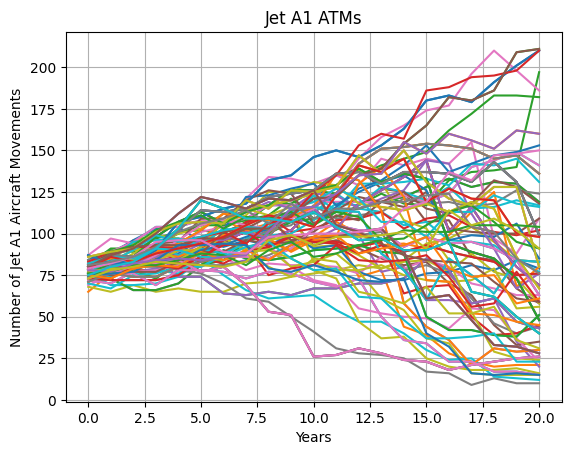

In [184]:
d_ATM_LH, d_ATM_LH_mix = fn.LH2_technology_adoption(Param, S_value_matrix, d_ATM_mix)

# fn.Scenario_plot(Param, d_ATM_LH, True, "LH2 ATMs", "Number of LH2 Aircraft Movements")
# fn.ATM_plot(d_ATM_LH_mix, Param)

d_ATM_Jet = d_ATM - d_ATM_LH
fn.Scenario_plot(
    Param, d_ATM_Jet, True, "Jet A1 ATMs", "Number of Jet A1 Aircraft Movements"
)

d_ATM_Jet_mix = np.round(d_ATM_mix - d_ATM_LH_mix, 0)
# fn.ATM_plot(d_ATM_Jet_mix, Param)

Current suspicion - K_Yearly is not properly defined

In [185]:
# delta_K_Jet_Test_old_0 = np.array(
#     [0, 0, 0, 0, 4, 0, 0, 0, 6, 2, 6, 0, 0, 0, 0, 0, 6, 0, 0, 12, 0]
# )

# delta_K_Jet_Test_old_1 = np.array(
#     [10, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 10]
# )

# delta_K_Jet_Test_old_2 = np.array(
#     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# )
# delta_K_Jet_Test_0 = np.tile(delta_K_Jet_Test_old_0, (Param["No_Forecasts"], 1))
# k_Jet_Test_0 = fn.Capacity_2D(Param, delta_K_Jet_Test_0)

# delta_K_Jet_Test_1 = np.tile(delta_K_Jet_Test_old_1, (Param["No_Forecasts"], 1))
# k_Jet_Test_1 = fn.Capacity_2D(Param, delta_K_Jet_Test_1)

# delta_K_Jet_Test_2 = np.tile(delta_K_Jet_Test_old_2, (Param["No_Forecasts"], 1))
# k_Jet_Test_2 = fn.Capacity_2D(Param, delta_K_Jet_Test_2)

# delta_K_LH_Test_old = np.array(
#     [2, 0, 0, 0, 2, 0, 0, 0, 0, 6, 0, 0, 0, 6, 6, 0, 0, 6, 6, 0, 0]
# )
# delta_K_LH_Test = np.tile(delta_K_LH_Test_old, (Param["No_Forecasts"], 1))
# k_LH_Test = fn.Capacity_2D(Param, delta_K_LH_Test, True)

# # Yearly
# K_Jet_Test_Yearly_0, K_Jet_Test_Yearly_Mix = fn.ATM_yearly(Param, k_Jet_Test_0)
# K_Jet_Test_Yearly_1, K_Jet_Test_Yearly_Mix = fn.ATM_yearly(Param, k_Jet_Test_1)
# K_Jet_Test_Yearly_2, K_Jet_Test_Yearly_Mix = fn.ATM_yearly(Param, k_Jet_Test_2)
# K_LH_Test_Yearly, K_LH_Test_Yearly_Mix = fn.ATM_yearly(Param, k_LH_Test)
# D_Jet_Test_Yearly, D_Jet_Test_Yearly_Mix = fn.ATM_yearly(Param, d_ATM_Jet)
# D_LH_Test_Yearly, D_LH_Test_Yearly_Mix = fn.ATM_yearly(Param, d_ATM_LH)

In [186]:
# fn.Scenario_plot(Param, np.vstack((D_Jet_Test_Yearly, K_Jet_Test_Yearly_0)))
# fn.Scenario_plot(Param, np.vstack((D_Jet_Test_Yearly, K_Jet_Test_Yearly_1)))
# fn.Scenario_plot(Param, np.vstack((D_Jet_Test_Yearly, K_Jet_Test_Yearly_2)))

In [187]:
# # Capex
# Capex_Jet_Test_0 = fn.Capex_Jet(Param, delta_K_Jet_Test_0)
# Capex_Jet_Test_1 = fn.Capex_Jet(Param, delta_K_Jet_Test_1)
# Capex_Jet_Test_2 = fn.Capex_Jet(Param, delta_K_Jet_Test_2)
# Capex_LH_Test = fn.Capex_LH(Param, delta_K_LH_Test, D_LH_Test_Yearly)

# # Opex
# Opex_Jet = fn.Opex_Jet(
#     Param, k_Jet_Test_1, d_ATM_LH, K_Jet_Test_Yearly_1, D_Jet_Test_Yearly
# )
# Opex_LH = fn.Opex_LH(Param, k_LH_Test, d_ATM_LH, K_LH_Test_Yearly, D_LH_Test_Yearly)
# Opex_terminal = fn.Opex_Terminal(Param, Shock_Scenarios)

# # Revenues
# Rev_Jet_0 = fn.Revenue_Jet(
#     Param, k_Jet_Test_0, d_ATM_Jet, K_Jet_Test_Yearly_0, D_Jet_Test_Yearly
# )
# Rev_Jet_1 = fn.Revenue_Jet(
#     Param, k_Jet_Test_1, d_ATM_Jet, K_Jet_Test_Yearly_1, D_Jet_Test_Yearly
# )
# Rev_Jet_2 = fn.Revenue_Jet(
#     Param, k_Jet_Test_2, d_ATM_Jet, K_Jet_Test_Yearly_2, D_Jet_Test_Yearly
# )
# Rev_LH = fn.Revenue_LH(Param, k_LH_Test, d_ATM_LH, K_LH_Test_Yearly, D_LH_Test_Yearly)
# Rev_Rent = fn.Revenue_Rent(Param, d_ATM_Jet, d_ATM_LH)

# Rev_Pax = fn.Revenue_Pax(
#     Param,
#     Shock_Scenarios,
#     (K_Jet_Test_Yearly_0 + K_LH_Test_Yearly),
#     (D_Jet_Test_Yearly + D_LH_Test_Yearly),
# )

In [188]:
# Profit_0 = Rev_Jet_0 - (Capex_Jet_Test_0 + Opex_Jet)
# print(np.sum(Profit_0))
# Profit_1 = Rev_Jet_1 - (Capex_Jet_Test_1 + Opex_Jet)
# print(np.sum(Profit_1))
# Profit_2 = Rev_Jet_2 - (Capex_Jet_Test_2 + Opex_Jet)
# print(np.sum(Profit_2))

In [189]:
# fn.Scenario_plot(
#     Param,
#     np.vstack((Profit_0, Profit_1, Profit_2)),
#     True,
#     "Profit Jet",
#     "Profit Jet in USD",
# )

# fn.Scenario_plot(Param, Profit_0)
# fn.Scenario_plot(Param, Profit_1)
# fn.Scenario_plot(Param, Profit_2)

In [190]:
# fn.Scenario_plot(
#     Param,
#     np.vstack(((Capex_Jet_Test_0 + Opex_Jet), Rev_Jet_0)),
#     True,
#     "Cost Jet 0 vs Rev Jet",
#     "Cost Jet vs Rev in USD",
# )

# fn.Scenario_plot(
#     Param,
#     np.vstack((Profit_0)),
#     True,
#     "Profit Jet 0",
#     "Profit Jet 0 in USD",
# )


# fn.Scenario_plot(
#     Param,
#     np.vstack(((Capex_Jet_Test_1 + Opex_Jet), Rev_Jet_1)),
#     True,
#     "Cost Jet 1 vs Rev Jet",
#     "Cost Jet vs Rev in USD",
# )
# fn.Scenario_plot(
#     Param,
#     np.vstack((Profit_1)),
#     True,
#     "Profit Jet 1",
#     "Profit Jet 1 in USD",
# )
# fn.Scenario_plot(
#     Param,
#     np.vstack(((Capex_Jet_Test_2 + Opex_Jet), Rev_Jet_2)),
#     True,
#     "Cost Jet 2 vs Rev Jet",
#     "Cost Jet vs Rev in USD",
# )
# fn.Scenario_plot(
#     Param,
#     np.vstack((Profit_2)),
#     True,
#     "Profit Jet 2",
#     "Profit Jet 2 in USD",
# )


# fn.Scenario_plot(
#     Param,
#     np.vstack(((Capex_Jet_Test_1 + Opex_Jet))),
#     True,
#     "Capex Jet + Opex Jet",
#     "Capex + Opex Jet in USD",
# )
# fn.Scenario_plot(
#     Param,
#     Opex_Jet,
#     True,
#     "Opex Jet A1",
#     "Opex Jet A1 in USD",
# )


# # fn.Scenario_plot(
# #     Param,
# #     np.vstack(((Capex_LH_Test + Opex_LH), Rev_LH)),
# #     True,
# #     "Capex LH",
# #     "Capex LH in USD",
# # )


# # fn.Scenario_plot(Param, Capex_LH_Test, True, "Capex LH", "Capex LH in USD")

In [191]:
# # fn.Scenario_plot(
# #     Param,
# #     Opex_terminal,
# #     True,
# #     "Opex Terminal",
# #     "Opex Terminal in USD per Year",
# # )

# Rev = Rev_Rent + Rev_Pax

# # fn.Scenario_plot(
# #     Param,
# #     Rev,
# #     True,
# #     "Total Revenue",
# #     "Revenue in USD per Year",
# # )
# # fn.Scenario_plot(
# #     Param,
# #     Rev_Rent,
# #     True,
# #     "Revenue Rent",
# #     "Revenue Rent in USD per Year",
# # )
# # fn.Scenario_plot(
# #     Param,
# #     Rev_Pax,
# #     True,
# #     "Revenue Pax",
# #     "Revenue Pax in USD per Year",
# # )
# fn.Scenario_plot(
#     Param,
#     np.vstack((Opex_terminal, Rev)),
#     True,
#     "Opex/Total Revenue Terminal",
#     "Opex Terminal in USD per Year",
# )

In [192]:
# fn.Scenario_plot(Param, np.vstack((k_Jet_Test_0, d_ATM_Jet)))
# fn.Scenario_plot(Param, np.vstack((k_Jet_Test_1, d_ATM_Jet)))
# fn.Scenario_plot(Param, np.vstack((k_Jet_Test_2, d_ATM_Jet)))

In [193]:
# Total_cost_0 = fn.Total_Cost_calculation(
#     Param,
#     delta_K_Jet_Test_0,
#     delta_K_LH_Test,
#     k_Jet_Test_0,
#     k_LH_Test,
#     d_ATM_Jet,
#     d_ATM_LH,
#     Shock_Scenarios,
#     K_Jet_Test_Yearly_0,
#     K_LH_Test_Yearly,
#     D_Jet_Test_Yearly,
#     D_LH_Test_Yearly,
# )

# Total_cost_1 = fn.Total_Cost_calculation(
#     Param,
#     delta_K_Jet_Test_1,
#     delta_K_LH_Test,
#     k_Jet_Test_1,
#     k_LH_Test,
#     d_ATM_Jet,
#     d_ATM_LH,
#     Shock_Scenarios,
#     K_Jet_Test_Yearly_1,
#     K_LH_Test_Yearly,
#     D_Jet_Test_Yearly,
#     D_LH_Test_Yearly,
# )

# Total_cost_2 = fn.Total_Cost_calculation(
#     Param,
#     delta_K_Jet_Test_2,
#     delta_K_LH_Test,
#     k_Jet_Test_2,
#     k_LH_Test,
#     d_ATM_Jet,
#     d_ATM_LH,
#     Shock_Scenarios,
#     K_Jet_Test_Yearly_2,
#     K_LH_Test_Yearly,
#     D_Jet_Test_Yearly,
#     D_LH_Test_Yearly,
# )
# # fn.Scenario_plot(Param, Total_cost_0, True, "Total_cost_0")
# # fn.Scenario_plot(Param, Total_cost_1, True, "Total_cost_1")
# # fn.Scenario_plot(Param, Total_cost_2, True, "Total_cost_2")
# # fn.Scenario_plot(
# #     Param, np.vstack((Total_cost_0, Total_cost_1, Total_cost_2)), True, "Total_cost_2"
# # )

In [194]:
# Total_Revenue_0 = fn.Total_Revenue_calculation(
#     Param,
#     k_Jet_Test_0,
#     k_LH_Test,
#     d_ATM_Jet,
#     d_ATM_LH,
#     Shock_Scenarios,
#     K_Jet_Test_Yearly_0,
#     K_LH_Test_Yearly,
#     D_Jet_Test_Yearly,
#     D_LH_Test_Yearly,
# )

# Total_Revenue_1 = fn.Total_Revenue_calculation(
#     Param,
#     k_Jet_Test_1,
#     k_LH_Test,
#     d_ATM_Jet,
#     d_ATM_LH,
#     Shock_Scenarios,
#     K_Jet_Test_Yearly_1,
#     K_LH_Test_Yearly,
#     D_Jet_Test_Yearly,
#     D_LH_Test_Yearly,
# )

# Total_Revenue_2 = fn.Total_Revenue_calculation(
#     Param,
#     k_Jet_Test_2,
#     k_LH_Test,
#     d_ATM_Jet,
#     d_ATM_LH,
#     Shock_Scenarios,
#     K_Jet_Test_Yearly_2,
#     K_LH_Test_Yearly,
#     D_Jet_Test_Yearly,
#     D_LH_Test_Yearly,
# )

# # fn.Scenario_plot(Param, Total_Revenue_0, True, "Total_Revenue_0")
# # fn.Scenario_plot(Param, Total_Revenue_1, True, "Total_Revenue_1")
# # fn.Scenario_plot(Param, Total_Revenue_2, True, "Total_Revenue_2")
# # fn.Scenario_plot(
# #     Param,
# #     np.vstack((Total_Revenue_0, Total_Revenue_1, Total_Revenue_2)),
# #     True,
# #     "Total_Revenue",
# # )

In [195]:
# fn.Scenario_plot(
#     Param,
#     np.vstack(
#         (
#             Total_Revenue_0,
#             Total_Revenue_1,
#             Total_Revenue_2,
#             Total_cost_0,
#             Total_cost_1,
#             Total_cost_2,
#         )
#     ),
#     True,
#     "Rev and Cost all",
# )
# fn.Scenario_plot(Param, Total_Revenue_0, True, "Total_Revenue_0")
# fn.Scenario_plot(
#     Param,
#     np.vstack(
#         (
#             Total_Revenue_0,
#             Total_cost_0,
#         )
#     ),
#     True,
#     "Rev and Cost 0",
# )
# fn.Scenario_plot(
#     Param,
#     np.vstack(
#         (
#             Total_Revenue_1,
#             Total_cost_1,
#         )
#     ),
#     True,
#     "Rev and Cost 1",
# )
# fn.Scenario_plot(
#     Param,
#     np.vstack(
#         (
#             Total_Revenue_2,
#             Total_cost_2,
#         )
#     ),
#     True,
#     "Rev and Cost 2",
# )

# Completed Scenarios

In [196]:
# Passenger Demand Scenario
print("Pax: \t\t", Shock_Scenarios.shape)

# Air Traffic Mix Scenario
print("ATM Demand: \t", d_ATM.shape)
print("ATM Mix Demand: ", d_ATM_mix.shape)

# Technology Adoption Scenario
print("S-Curve Values: ", S_value_matrix.shape)

Pax: 		 (100, 21)
ATM Demand: 	 (100, 21)
ATM Mix Demand:  (100, 21, 3)
S-Curve Values:  (100, 21)


Yearly Stand Demand

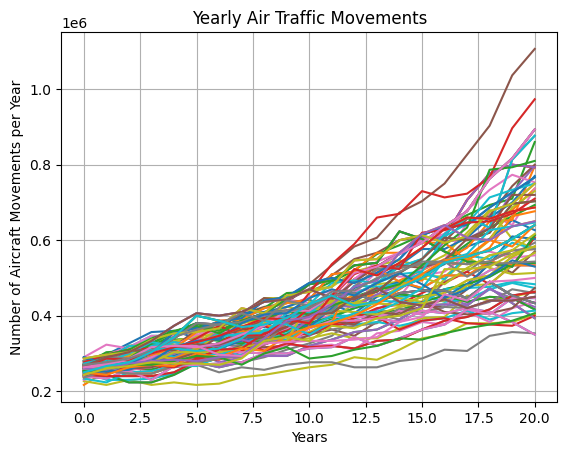

In [197]:
D_ATM, D_ATM_mix = fn.ATM_yearly(Param, d_ATM)

fn.Scenario_plot(
    Param,
    D_ATM,
    True,
    "Yearly Air Traffic Movements",
    "Number of Aircraft Movements per Year",
)

# fn.ATM_plot(D_ATM_mix, Param)

Yearly Stand Demand via Yearly Pax Demand (does not consider Load Factor!)

In [198]:
# D_ATM_new, D_ATM_mix_new = fn.ATM(Param, Shock_Scenarios, Load_Factor_matrix)
# fn.Scenario_plot(
#     Param,
#     D_ATM_new,
#     True,
#     "Total Air Traffic Movements",
#     "Number of Aircraft Movements in the Design Hour",
# )

Difference between ATM via Shock Pax and ATM via DHL calculation

In [199]:
# difference = D_ATM_new - D_ATM
# # print("Difference between new and old ATM:", difference)
# fn.Scenario_plot(
#     Param,
#     difference,
#     True,
#     "Difference in ATMs",
#     "Difference in Number of Aircraft Movements",
# )

# Optimization Alorithm

In [200]:
GA_dual = fn.GA_dual(Param, d_ATM_mix, S_value_matrix, Shock_Scenarios)
delta_K_GA = GA_dual[0] + GA_dual[1]

print(delta_K_GA.shape)
# print(delta_K_GA)

(100, 21, 3)


In [201]:
NPV_GA = fn.NPV_calculation(
    Param,
    GA_dual[0],
    GA_dual[1],
    d_ATM_mix,
    S_value_matrix,
    Shock_Scenarios,
)

# print(NPV_GA)

Visulization Jet

In [202]:
# K_GA_Jet = fn.Capacity_2D(Param, GA_dual[0])
# fn.Scenario_plot(Param, K_GA_Jet, True, "GA Output Jet", "Capacity K Jet")
# fn.Scenario_plot(
#     Param,
#     np.vstack((K_GA_Jet, d_ATM_Jet)),
#     True,
#     "GA Output Jet",
#     "Capacity K Jet",
# )

Visualization LH

In [203]:
# K_GA_LH = fn.Capacity_2D(Param, GA_dual[1], True)
# fn.Scenario_plot(Param, K_GA_LH, True, "GA Output LH", "Capacity K LH")
# fn.Scenario_plot(
#     Param,
#     np.vstack((K_GA_LH, d_ATM_LH)),
#     True,
#     "GA Output LH",
#     "Capacity K LH",
# )

Total Capacity

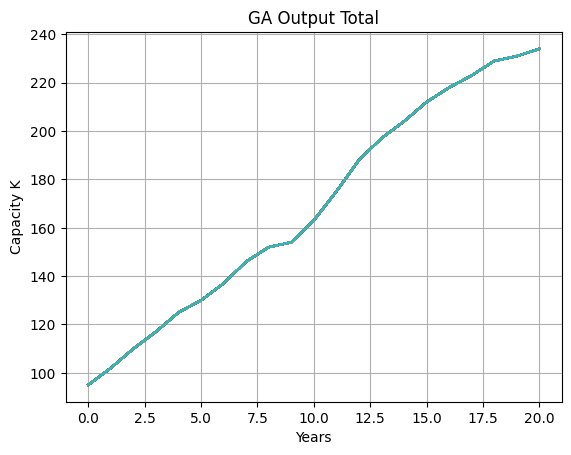

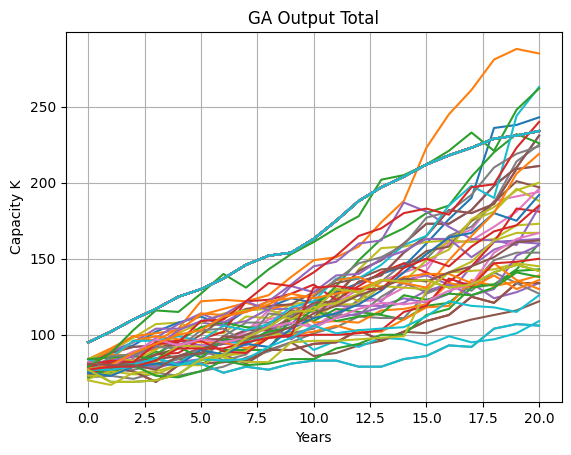

In [204]:
K_GA_total = fn.Capacity_2D(Param, delta_K_GA)

fn.Scenario_plot(Param, K_GA_total, True, "GA Output Total", "Capacity K")
fn.Scenario_plot(
    Param, np.vstack((K_GA_total, d_ATM)), True, "GA Output Total", "Capacity K"
)

In [205]:
k_GA, k_GA_mix = fn.K_yearly(Param, K_GA_total)

# Decision Rule

Parameters for Decision Rule Optimization

In [206]:
Param["lower_theta"] = 0
Param["upper_theta"] = 12
Param["stepsize_theta"] = 1
Param["lower_condition"] = -1
Param["upper_condition"] = 2
Param["stepsize_condition"] = 1

In [207]:
# Test = fn.Parameter_combinations(Param, 100)
# # print("Test shape:", Test)

Parameter Evaluation

In [208]:
# Parameter_Evaluation
ENPV_Decision, Parameter_Decision = fn.Parameter_Evaluation(
    Param,
    d_ATM_Jet_mix,
    d_ATM_LH_mix,
    d_ATM_mix,
    S_value_matrix,
    Shock_Scenarios,
    15000,
    False,
)
print("Maximum ENPV:", ENPV_Decision)
print("Best Parameters:", Parameter_Decision)

Maximum ENPV: 291854276.28683656
Best Parameters: (5, -1, 9, -1)


In [209]:
# # Parameter_Evaluation
# ENPV_Decision, Parameter_Decision = fn.Parameter_Evaluation(
#     Param, d_ATM_Jet, d_ATM_LH, d_ATM, S_value_matrix, Shock_Scenarios, 15000, False
# )
# print("Maximum ENPV:", ENPV_Decision)
# print("Best Parameters:", Parameter_Decision)

In [210]:
# Parameter_Evaluation
ENPV_Decision_2, Parameter_Decision_2 = fn.Parameter_Evaluation(
    Param,
    d_ATM_Jet_mix,
    d_ATM_LH_mix,
    d_ATM_mix,
    S_value_matrix,
    Shock_Scenarios,
    15000,
    True,
)
print("Maximum ENPV:", ENPV_Decision_2)
print("Best Parameters:", Parameter_Decision_2)

Maximum ENPV: 292663166.4758358
Best Parameters: (8, 5, 3, -1, 10, 8, 4, -1)


Decision Rule 0

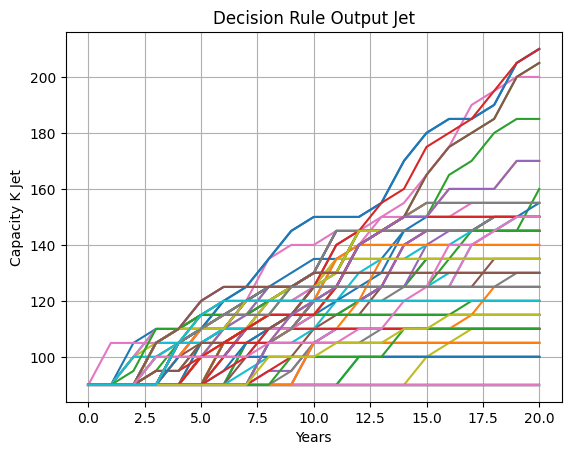

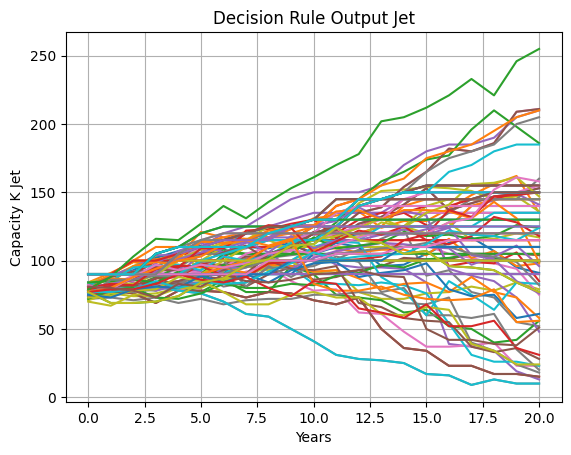

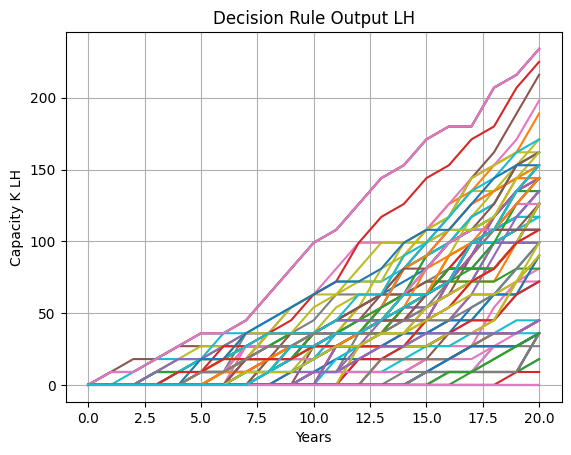

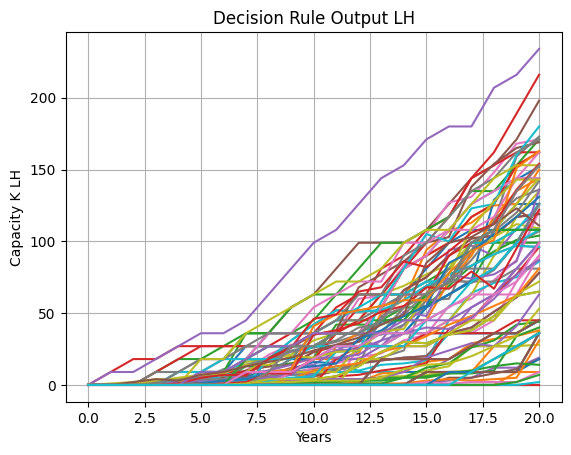

In [211]:
delta_K_Jet_Decision_0 = fn.Decision_Rule(
    Param, Param["K0"], d_ATM_Jet_mix, Parameter_Decision[0], Parameter_Decision[1]
)
K_Jet_Decision_0 = fn.Capacity_2D(Param, delta_K_Jet_Decision_0)
fn.Scenario_plot(
    Param, K_Jet_Decision_0, True, "Decision Rule Output Jet", "Capacity K Jet"
)
fn.Scenario_plot(
    Param,
    np.vstack((K_Jet_Decision_0, d_ATM_Jet)),
    True,
    "Decision Rule Output Jet",
    "Capacity K Jet",
)

delta_K_LH_Decision_0 = fn.Decision_Rule(
    Param, Param["K0_LH"], d_ATM_LH_mix, Parameter_Decision[2], Parameter_Decision[3]
)
K_LH_Decision_0 = fn.Capacity_2D(Param, delta_K_LH_Decision_0, True)
fn.Scenario_plot(
    Param, K_LH_Decision_0, True, "Decision Rule Output LH", "Capacity K LH"
)
fn.Scenario_plot(
    Param,
    np.vstack((K_LH_Decision_0, d_ATM_LH)),
    True,
    "Decision Rule Output LH",
    "Capacity K LH",
)

Decision 2

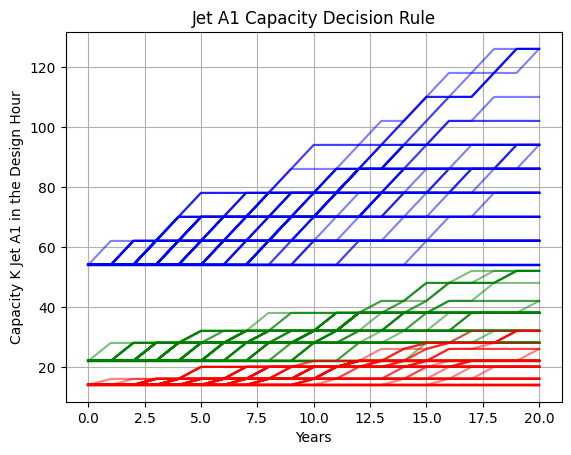

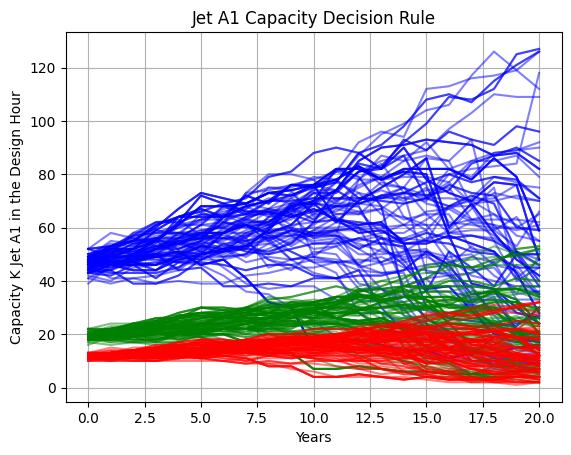

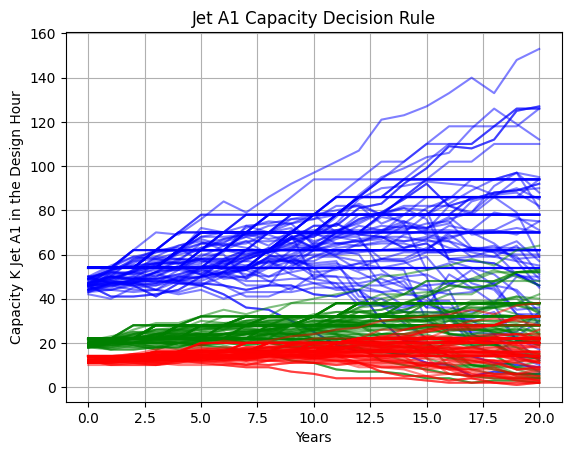

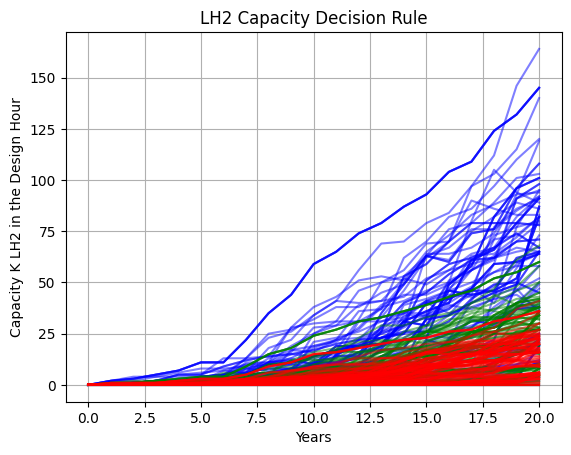

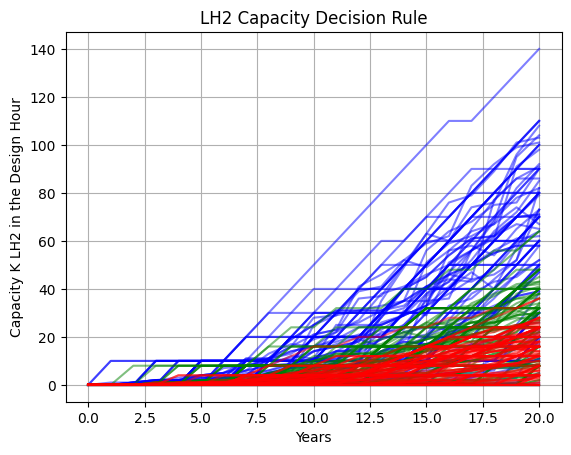

In [212]:
delta_K_Jet_short = fn.Decision_Rule(
    Param,
    Param["K0"] * Param["Mix"][0],
    d_ATM_Jet_mix[:, :, 0],
    Parameter_Decision_2[0],
    Parameter_Decision_2[3],
)
delta_K_Jet_medium = fn.Decision_Rule(
    Param,
    Param["K0"] * Param["Mix"][1],
    d_ATM_Jet_mix[:, :, 1],
    Parameter_Decision_2[1],
    Parameter_Decision_2[3],
)
delta_K_Jet_long = fn.Decision_Rule(
    Param,
    Param["K0"] * Param["Mix"][2],
    d_ATM_Jet_mix[:, :, 2],
    Parameter_Decision_2[2],
    Parameter_Decision_2[3],
)
delta_K_Jet_Decision_2 = np.stack(
    [delta_K_Jet_short, delta_K_Jet_medium, delta_K_Jet_long], axis=2
)
delta_K_LH_short = fn.Decision_Rule(
    Param,
    Param["K0_LH"] * Param["Mix"][0],
    d_ATM_LH_mix[:, :, 0],
    Parameter_Decision_2[4],
    Parameter_Decision_2[7],
)
delta_K_LH_medium = fn.Decision_Rule(
    Param,
    Param["K0_LH"] * Param["Mix"][1],
    d_ATM_LH_mix[:, :, 1],
    Parameter_Decision_2[5],
    Parameter_Decision_2[7],
)
delta_K_LH_long = fn.Decision_Rule(
    Param,
    Param["K0_LH"] * Param["Mix"][2],
    d_ATM_LH_mix[:, :, 2],
    Parameter_Decision_2[6],
    Parameter_Decision_2[7],
)
delta_K_LH_Decision_2 = np.stack(
    [delta_K_LH_short, delta_K_LH_medium, delta_K_LH_long], axis=2
)

k_Jet_Decision_2 = fn.Capacity_3D(Param, delta_K_Jet_Decision_2)

fn.Scenario_plot(
    Param,
    k_Jet_Decision_2,
    True,
    "Jet A1 Capacity Decision Rule",
    "Capacity K Jet A1 in the Design Hour",
)

fn.Scenario_plot(
    Param,
    d_ATM_Jet_mix,
    True,
    "Jet A1 Capacity Decision Rule",
    "Capacity K Jet A1 in the Design Hour",
)

fn.Scenario_plot(
    Param,
    np.vstack((k_Jet_Decision_2, d_ATM_Jet_mix)),
    True,
    "Jet A1 Capacity Decision Rule",
    "Capacity K Jet A1 in the Design Hour",
)

k_LH_Decision_2 = fn.Capacity_3D(Param, delta_K_LH_Decision_2, True)

fn.Scenario_plot(
    Param,
    d_ATM_LH_mix,
    True,
    "LH2 Capacity Decision Rule",
    "Capacity K LH2 in the Design Hour",
)
fn.Scenario_plot(
    Param,
    np.vstack((k_LH_Decision_2, d_ATM_LH_mix)),
    True,
    "LH2 Capacity Decision Rule",
    "Capacity K LH2 in the Design Hour",
)

Decision 3

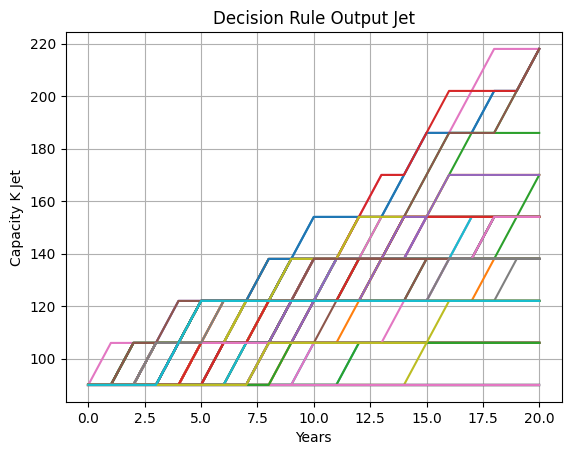

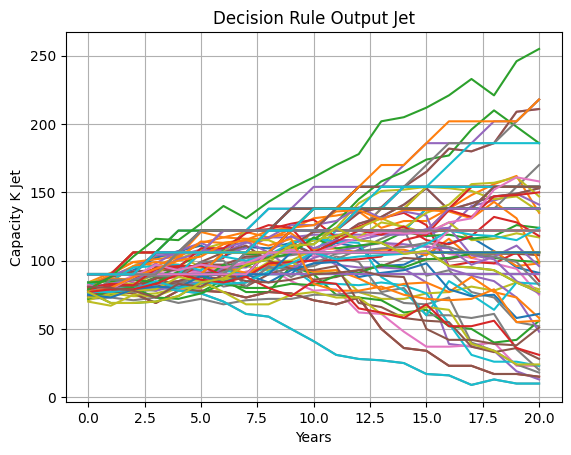

In [213]:
cond_Jet_Decision_3 = Parameter_Decision_2[3]
theta_Jet_Decision_3 = (
    Parameter_Decision_2[0] + Parameter_Decision_2[1] + Parameter_Decision_2[2]
)


delta_K_Jet_Decision_3 = fn.Decision_Rule(
    Param, Param["K0"], d_ATM_Jet, theta_Jet_Decision_3, cond_Jet_Decision_3
)
K_Jet_Decision_3 = fn.Capacity_2D(Param, delta_K_Jet_Decision_3)
fn.Scenario_plot(
    Param, K_Jet_Decision_3, True, "Decision Rule Output Jet", "Capacity K Jet"
)
fn.Scenario_plot(
    Param,
    np.vstack((K_Jet_Decision_3, d_ATM_Jet)),
    True,
    "Decision Rule Output Jet",
    "Capacity K Jet",
)

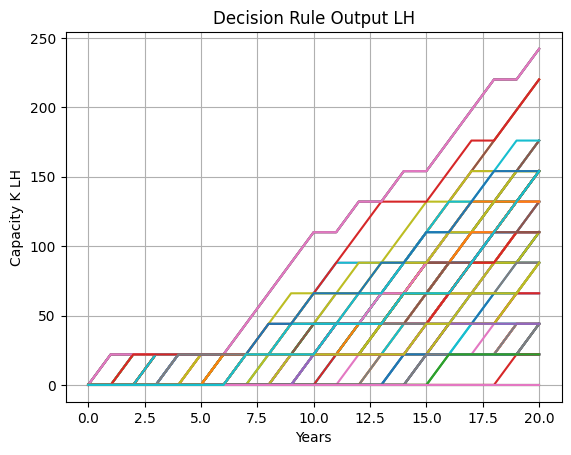

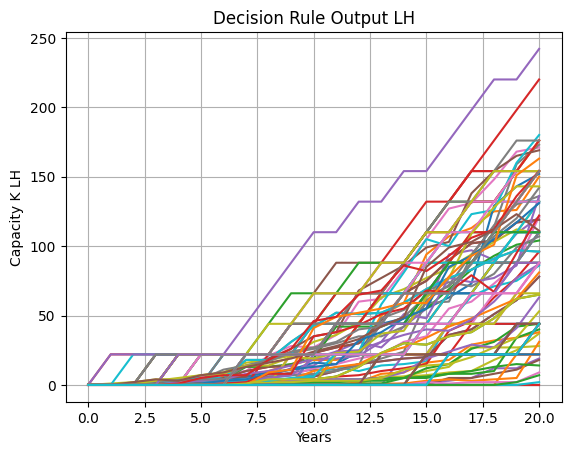

In [214]:
cond_LH_Decision_3 = Parameter_Decision_2[7]
theta_LH_Decision_3 = (
    Parameter_Decision_2[4] + Parameter_Decision_2[5] + Parameter_Decision_2[6]
)

delta_K_LH_Decision_3 = fn.Decision_Rule(
    Param, Param["K0_LH"], d_ATM_LH, theta_LH_Decision_3, cond_LH_Decision_3
)
K_LH_Decision_3 = fn.Capacity_2D(Param, delta_K_LH_Decision_3, True)
fn.Scenario_plot(
    Param, K_LH_Decision_3, True, "Decision Rule Output LH", "Capacity K LH"
)
fn.Scenario_plot(
    Param,
    np.vstack((K_LH_Decision_3, d_ATM_LH)),
    True,
    "Decision Rule Output LH",
    "Capacity K LH",
)

NPV

In [215]:
NPV_Decision = fn.NPV_calculation(
    Param,
    delta_K_Jet_Decision_0,
    delta_K_LH_Decision_0,
    d_ATM_mix,
    S_value_matrix,
    Shock_Scenarios,
)

print(np.mean(NPV_Decision))
print(ENPV_Decision)

291854276.28683656
291854276.28683656


In [216]:
NPV_Decision_2 = fn.NPV_calculation(
    Param,
    delta_K_Jet_Decision_2,
    delta_K_LH_Decision_2,
    d_ATM_mix,
    S_value_matrix,
    Shock_Scenarios,
)

print(np.mean(NPV_Decision_2))
print(ENPV_Decision_2)

292663166.4758358
292663166.4758358


In [217]:
NPV_Decision_3 = fn.NPV_calculation(
    Param,
    delta_K_Jet_Decision_3,
    delta_K_LH_Decision_3,
    d_ATM_mix,
    S_value_matrix,
    Shock_Scenarios,
)

print(np.mean(NPV_Decision_3))
# print(ENPV_Decision_3)

293916114.58918226


### CDF Plot

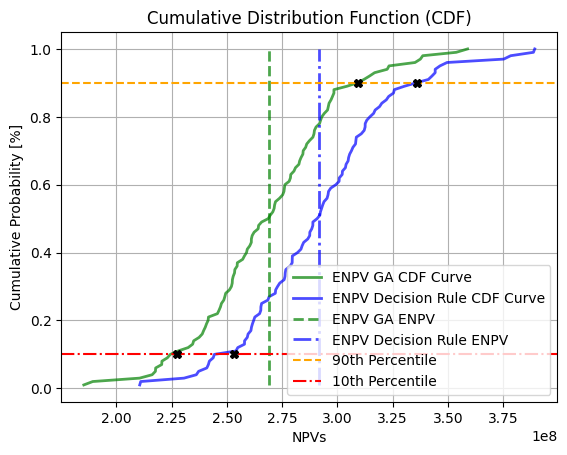

ENPV_GA: 		 268929287.05289
ENPV_Decision Rule: 	 291854276.28683656


In [218]:
fn.CDF_Plot(
    NPV_GA,
    NPV_Decision,
    "ENPV GA",
    "ENPV Decision Rule",
)
print("ENPV_GA: \t\t", np.mean(NPV_GA))
print("ENPV_Decision Rule: \t", ENPV_Decision)

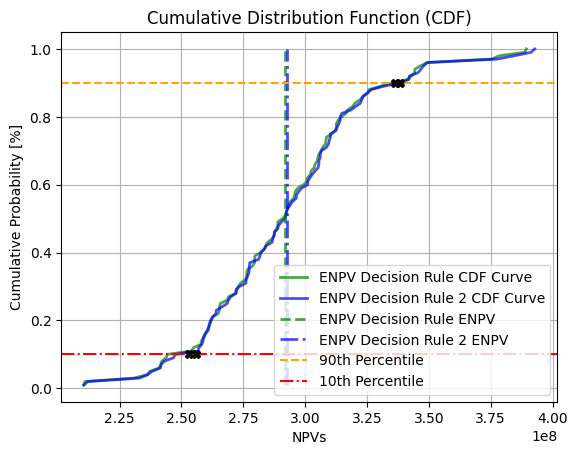

ENPV_Decision Rule: 	 291854276.28683656
ENPV_Decision Rule 2: 	 292663166.4758358


In [219]:
fn.CDF_Plot(
    NPV_Decision,
    NPV_Decision_2,
    "ENPV Decision Rule",
    "ENPV Decision Rule 2",
)
print("ENPV_Decision Rule: \t", ENPV_Decision)
print("ENPV_Decision Rule 2: \t", np.mean(NPV_Decision_2))

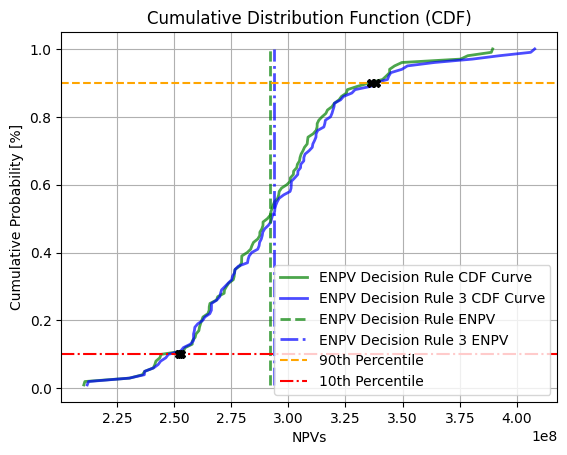

ENPV_Decision Rule: 	 291854276.28683656
ENPV_Decision Rule 3: 	 293916114.58918226


In [228]:
fn.CDF_Plot(
    NPV_Decision,
    NPV_Decision_3,
    "ENPV Decision Rule",
    "ENPV Decision Rule 3",
)
print("ENPV_Decision Rule: \t", ENPV_Decision)
print("ENPV_Decision Rule 3: \t", np.mean(NPV_Decision_3))

# Stopping the Runtime

In [221]:
end_time = time.time()

# Calculate the Total Runtime
total_run_time = end_time - start_time

# Display the Total Runtime
print("Total Runtime \t=", round(total_run_time, 2), "s")
print("Total Runtime \t=", round(total_run_time / 60, 2), "min")
print("Total Runs \t=", Param["No_Forecasts"])

Total Runtime 	= 69.47 s
Total Runtime 	= 1.16 min
Total Runs 	= 100


I adjusted the second smoothing (smoothing of Load Factor). Currently it is out commented in the Function as it safes 1/3 of the time. For "No_Forecasts": 30000 the Code takes 20 instead of 30 seconds.

## Multiprocessing

In [222]:
# import multiprocessing


# input_list = [Param.copy() for _ in range(Param["No_Forecasts"])]

# # Create a pool of worker processes
# with multiprocessing.Pool(processes=8) as pool:
#     results = pool.map(fn.ATM, input_list)  # Map function to pool

In [223]:
# from multiprocessing import Pool

# # input_list = list of each scenario (rows of Shock_forecast)
# input_list = [row for row in Shock_Scenarios]  # shape: [No_Forecasts, Fth]
# args_list = [(Param, scenario) for scenario in input_list]

# with Pool(processes=8) as pool:
#     results = pool.starmap(fn.Load_Factor_matrix, args_list)

In [224]:
# import multiprocessing as mp


# # Helper function for multiprocessing
# def compute_load_factor(scenario):
#     return fn.Load_Factor_matrix(Param, scenario)


# if __name__ == "__main__":
#     # Number of processes (or use mp.cpu_count())
#     pool = mp.Pool(processes=4)

#     # Map each scenario to the worker pool
#     results = pool.map(compute_load_factor, Shock_Scenarios)

#     pool.close()
#     pool.join()

#     # Combine results if needed (e.g., into a matrix)
#     LF_test_matrix = np.array(results)  # Or pd.DataFrame(results), etc.

Loading Bar

In [225]:
# from tqdm.auto import tqdm

Example Usage

In [226]:
# # Generate input list with separate dictionary copies
# input_list = [Param.copy() for _ in range(Param["No_Forecasts"])]

# # Create a pool of worker processes
# with multiprocessing.Pool(processes=8) as pool:
#     # Use imap_unordered for better progress tracking with tqdm
#     results = list(
#         tqdm(
#             pool.imap_unordered(fn.ATM, input_list),
#             total=len(input_list),
#             desc="Processing Forecasts",
#         )
#     )